<a href="https://colab.research.google.com/github/MinhoKang/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,166 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [3]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304

Archive:  tpss_bcycl_od_statnhm_202304.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of tpss_bcycl_od_statnhm_202304.zip or
        tpss_bcycl_od_statnhm_202304.zip.zip, and cannot find tpss_bcycl_od_statnhm_202304.zip.ZIP, period.


## 12-2 CSV 형태의 데이터 수집

In [10]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)

## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230430,출발시간,0,ST-1124,상계2동_039_1,ST-1124,상계2동_039_1,2,0,10
1,20230430,출발시간,0,ST-1266,중곡1동_023_1,ST-1266,중곡1동_023_1,1,0,0
2,20230430,출발시간,0,ST-1483,진관동_038_4,ST-1483,진관동_038_4,1,0,0
3,20230430,출발시간,0,ST-1657,위례동_002_2,ST-1657,위례동_002_2,2,0,0
4,20230430,출발시간,0,ST-1667,상도1동_029_1,ST-1667,상도1동_029_1,1,0,0


## 12-3 기초 통계량 산출

In [12]:
## 수치형 데이터 요약 통계 출력
print('수치형 데이터 요약 통계: \n', df.describe().to_markdown())

## 범주형 데이터 요약 통계 출력
print('범주형 데이터 요약 통계 출력:\n', df.describe(include=['object']).to_markdown())


수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.00532e+06 |    7.00532e+06 |  7.00532e+06 |    7.00532e+06 |      7.00532e+06 |
| mean  | 2.02304e+07 | 1457.71        |  1.0683      |   22.2862      |   2656.98        |
| std   | 3.55994     |  563.972       |  0.294457    |   30.157       |   3611.39        |
| min   | 2.02304e+07 |    0           |  1           |    0           |      0           |
| 25%   | 2.02304e+07 | 1020           |  1           |    6           |    852           |
| 50%   | 2.02304e+07 | 1605           |  1           |   12           |   1547           |
| 75%   | 2.02304e+07 | 1900           |  1           |   26           |   2959           |
| max   | 2.02304e+07 | 2355           | 17           | 2001           | 293443           |
범주형 데이터 요약 통계 출력:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명

## 12-4 결측치 및 이상치 제거

In [17]:
## 결측치 제거
df=df.dropna()

## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]

## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]

## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

## 수치형 데이터 요약 통계 출력
print('수치형 데이터 요약 통계: \n', df.describe().to_markdown())

## 범주형 데이터 요약 통계 출력
print('범주형 데이터 요약 통계 출력:\n', df.describe(include=['object']).to_markdown())


수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 3.17359e+06 |    3.17359e+06 |  3.17359e+06 |    3.17359e+06 |      3.17359e+06 |
| mean  | 2.02304e+07 | 1437.52        |  1.05312     |   19.649       |   2210.92        |
| std   | 3.55487     |  564.061       |  0.249611    |   21.5772      |   1888.72        |
| min   | 2.02304e+07 |    0           |  1           |    2           |     11           |
| 25%   | 2.02304e+07 | 1005           |  1           |    6           |    928           |
| 50%   | 2.02304e+07 | 1550           |  1           |   12           |   1570           |
| 75%   | 2.02304e+07 | 1850           |  1           |   24           |   2798           |
| max   | 2.02304e+07 | 2355           | 13           |  179           |   9999           |
범주형 데이터 요약 통계 출력:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명

## 12-5 날짜/시간 데이터 형식 변환

In [20]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')

## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

df

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
154,2023-04-30,출발시간,205,ST-1714,가양1동_040_2,ST-1714,가양1동_040_2,2,2,30,일요일
2551,2023-04-30,출발시간,1745,ST-2486,공항동_006_2,ST-2486,공항동_006_2,3,2,80,일요일
2838,2023-04-30,출발시간,1850,ST-1660,자양3동_025_1,ST-1660,자양3동_025_1,2,2,110,일요일
6772,2023-04-30,출발시간,0,ST-1008,신월2동_026_1,ST-1005,신정1동_027_1,1,7,1120,일요일
6774,2023-04-30,출발시간,0,ST-1047,성내1동_023_1,ST-930,거여2동_001_1,1,23,4246,일요일
...,...,...,...,...,...,...,...,...,...,...,...
7005241,2023-04-21,출발시간,2335,ST-1191,자양4동_025_1,ST-1661,자양4동_005_1,5,40,5495,금요일
7005290,2023-04-21,출발시간,1905,ST-1005,신정1동_027_1,ST-2765,신정7동_028_1,6,123,3364,금요일
7005304,2023-04-21,출발시간,1025,ST-1333,묵1동_009_1,ST-558,묵2동_022_1,7,62,7689,금요일
7005305,2023-04-21,출발시간,1150,ST-655,종암동_029_1,ST-3046,종암동_003_1,7,87,5601,금요일


## 전처리 결과 확인

In [ ]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [21]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    302780
화요일    348954
수요일    591640
목요일    577364
금요일    603446
토요일    343896
일요일    405514
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

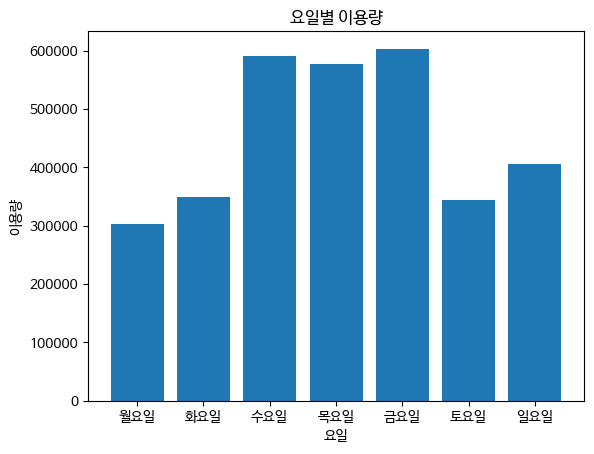

In [23]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)

plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

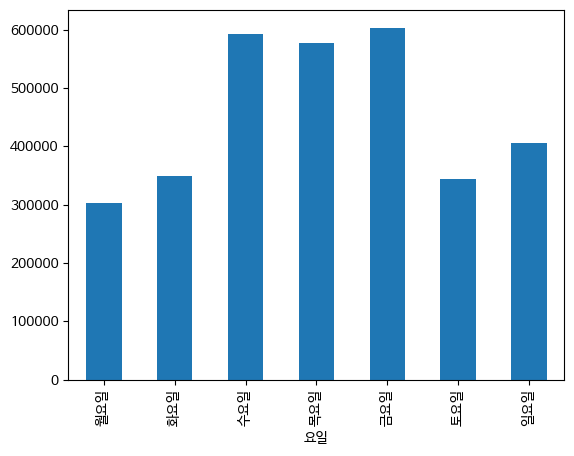

In [24]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')

plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0      69376
1      49114
2      31158
3      20552
4      15454
5      26852
6      59204
7     148384
8     227306
9     135708
10    105538
11    122354
12    136104
13    139640
14    147508
15    168314
16    210316
17    269850
18    333662
19    218842
20    174994
21    159714
22    135426
23     68224
Name: count, dtype: int64


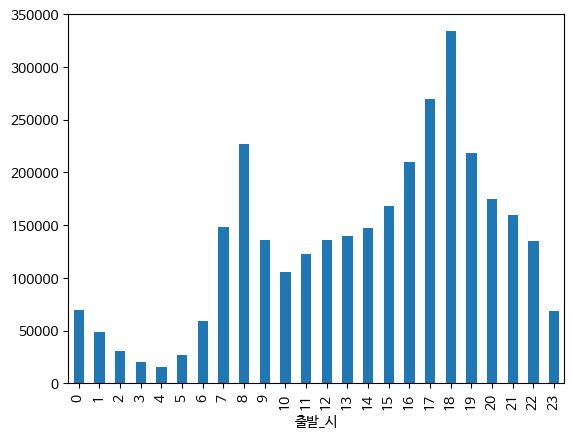

In [28]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대'] // 100

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-18    189318
2023-04-19    316690
2023-04-20    269764
2023-04-21    310890
2023-04-22    256350
2023-04-23    224372
2023-04-24    302780
2023-04-25    159636
2023-04-26    274950
2023-04-27    307600
2023-04-28    292556
2023-04-29     87546
2023-04-30    181142
Name: count, dtype: int64


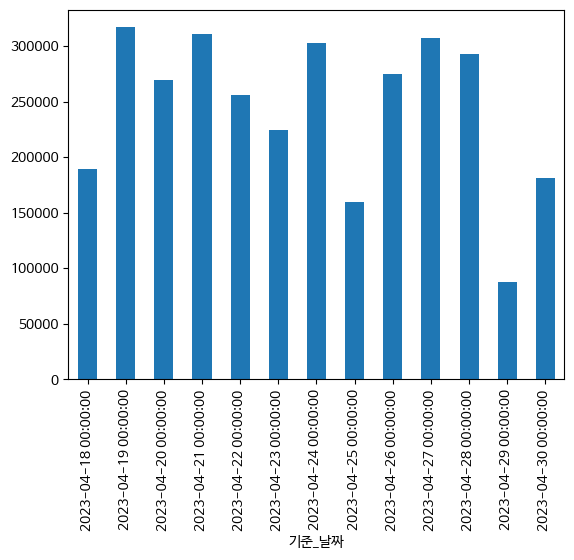

In [29]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [ ]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

## 12-11 강수량 데이터 전처리

In [ ]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기

## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [ ]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)

## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

## 12-13 이용량 및 강수량 시각화

In [ ]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기

## 두 번째 y축에 강수량 꺾은선 그래프 그리기


## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

In [ ]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성


## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [ ]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습

results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")